In [7]:
suppressMessages(library(ggplot2))
suppressMessages(library(ArchR))
suppressMessages(library(Seurat))
suppressMessages(library(Signac))
suppressMessages(library(ComplexHeatmap))
suppressMessages(library(BSgenome.Hsapiens.UCSC.hg38))
suppressMessages(library(circlize))

In [2]:
set.seed(42)
addArchRThreads(threads = 64)

Setting default number of Parallel threads to 64.



 - 特异性峰值

 - 特异性motif
 
 - 

In [3]:
proj <- loadArchRProject("./ArchRProject", showLogo = FALSE)

Successfully loaded ArchRProject!



In [4]:
VarMotifs <- getVarDeviations(proj, name = "homerMatrix", plot = F)

DataFrame with 6 rows and 6 columns
    seqnames       idx              name combinedVars combinedMeans      rank
       <Rle> <integer>       <character>    <numeric>     <numeric> <integer>
f87        z        87 FOXA1.Forkhead_87      68.3331   -0.65523535         1
f86        z        86     Fosl2.bZIP_86      64.1998    0.00507140         2
f1         z         1       AP.1.bZIP_1      63.3041    0.02254696         3
f99        z        99      Fra2.bZIP_99      62.8903    0.00733377         4
f94        z        94 FOXM1.Forkhead_94      62.5174   -0.64134957         5
f88        z        88 FOXA1.Forkhead_88      61.6128   -0.63294138         6


In [5]:
MotifScoreClusters <- getMarkerFeatures(proj, 
                                        useMatrix = "homerMatrix", 
                                        groupBy = "majorType",
                                        bias = c("TSSEnrichment", "log10(nFrags)"),
                                        testMethod = "wilcoxon", 
                                        useSeqnames = "z")

ArchR logging to : ArchRLogs/ArchR-getMarkerFeatures-2e4b4f7f5e873a-Date-2025-03-06_Time-08-16-06.501051.log
If there is an issue, please report to github with logFile!



MatrixClass = Sparse.Assays.Matrix

2025-03-06 08:16:06.890112 : Matching Known Biases, 0.002 mins elapsed.

###########
2025-03-06 08:16:23.495813 : Completed Pairwise Tests, 0.279 mins elapsed.
###########

ArchR logging successful to : ArchRLogs/ArchR-getMarkerFeatures-2e4b4f7f5e873a-Date-2025-03-06_Time-08-16-06.501051.log



In [8]:
fh <- function(x) hclust(dist(x), method="ward.D2")

In [10]:
idy <- which(mcols(MotifScoreClusters)$name %in% VarMotifs$name[c(1:50)])
mtx2 <- assays(MotifScoreClusters[idy,])$Mean %>% `rownames<-`(., mcols(MotifScoreClusters)$name[idy])

col_fun2 <- colorRamp2(c(-5,-2.5,0,2,5), paletteContinuous(set = "solarExtra", n = 5))
ht2 <- Heatmap(mtx2, name = "Mean motif score", cluster_rows = fh, cluster_columns = F, show_row_dend = F, col = col_fun2)
options(repr.plot.width=10, repr.plot.height=10)
svg("/data/hanxue/BCY_ATAC/joint_output/Mean-Motif-score.svg",width = 10, height = 10)
p6 <- draw(ht2)
dev.off()

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


pdf 
  2

In [11]:
plotPDF(ht2, name = "Mean-Motif-score.pdf", width = 10, height = 10, ArchRProj = proj, addDOC = FALSE)

Plotting ComplexHeatmap!



In [10]:
df <- reshape2::melt(table(proj@peakSet$peakType))
df

Var1,value
<fct>,<int>
Distal,114077
Exonic,26072
Intronic,177437
Promoter,27724


Plotting Ggplot!

Saving 6.67 x 6.67 in image


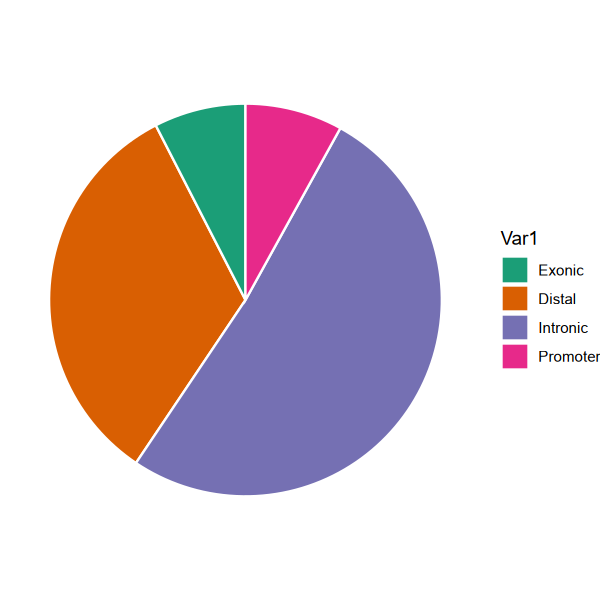

In [ ]:
options(repr.plot.width=5, repr.plot.height=5)
#----- peak profile， 峰值注释
# peaks类型分布统计 "Exonic", "Distal", "Intronic", "Promoter"
df <- reshape2::melt(table(proj@peakSet$peakType))
df$Var1 <- factor(df$Var1, levels = c("Exonic", "Distal", "Intronic", "Promoter"))

p8 <- ggplot(df, aes(x="", y= value, fill= Var1)) + 
       geom_bar(stat="identity", width=1, color="white") + 
       coord_polar("y", start=0) +
       theme_void() + scale_fill_brewer(palette="Dark2")
p8
plotPDF(p8, name = "CA_peakGenomicPosition.pdf", ArchRProj = proj, addDOC = FALSE, width = 5, height = 5)
ggsave("/data/hanxue/BCY_ATAC/joint_output/CA_peakGenomicPosition.svg",plot = p8, device = "svg")
# 与TCGA BRCA数据集的峰值重叠
tcga_bcPeaks <- import.bed("/data/hanxue/BCY_ATAC/TCGA/TCGA-BRCA-PeaksHg38.bed")
## 计算重叠峰值数
o <- findOverlaps(proj@peakSet, tcga_bcPeaks)
jfcr_overlap_no <- unique(queryHits(o)) %>% length()
tcga_overlap_no <- unique(subjectHits(o)) %>% length()
mtx <- matrix(c(length(proj@peakSet), jfcr_overlap_no, length(tcga_bcPeaks), tcga_overlap_no), ncol = 2, nrow = 2)
mtx <- rbind(mtx, (mtx[1,] - mtx[2,])) %>% `colnames<-`(.,c("scATAC", "TCGA")) %>% `rownames<-`(., c("Total", "Overlaps", "Nonoverlaps"))


In [18]:
## 展示重叠与非重叠峰值数
p9 <- ggplot(reshape2::melt(mtx[c(3,2),]), aes(x = Var2, y = value, fill = Var1)) + geom_bar(stat = "identity") + 
      theme_ArchR() + scale_fill_manual(values = c("lightgray", "darkorange"))
plotPDF(p9, name = "CA_peakTCGAoverlaps.pdf", ArchRProj = proj, addDOC = FALSE, width = 3, height = 5)
ggsave("/data/hanxue/BCY_ATAC/joint_output/CA_peakTCGAoverlaps.svg",plot = p9, device = "svg")
p9

Plotting Ggplot!

Saving 6.67 x 6.67 in image


In [19]:
## FRIP得分可视化
p10 <- plotGroups(proj, groupBy = "Sample", name = "FRIP", plotAs = "violin", alpha = 0.5)
p11 <- plotGroups(proj, groupBy = "Clusters", name = "FRIP", plotAs = "violin", alpha = 0.5)
ggsave("/data/hanxue/BCY_ATAC/joint_output/CA-FRIP-Sample.svg",plot = p10, device = "svg")
ggsave("/data/hanxue/BCY_ATAC/joint_output/CA-FRIP-Clusters.svg",plot = p11, device = "svg")
plotPDF(p10, p11, name = "CA_FRIP.pdf", ArchRProj = proj, addDOC = FALSE, width = 5, height = 5)
p10
p11

1 


Length of unique values greater than palette, interpolating..

1 


Saving 7 x 7 in image
Saving 7 x 7 in image
Plotting Ggplot!

Plotting Ggplot!



In [20]:
PeakCellType <- readRDS("./ArchRProject/markersPK_majorType.rds")

ArchR logging to : ArchRLogs/ArchR-plotMarkerHeatmap-90c0c592ebf8a-Date-2025-02-26_Time-11-12-56.347351.log
If there is an issue, please report to github with logFile!



Identified 136301 markers!



  [1] "chr1:1171711-1172211"   "chr1:1797889-1798389"   "chr1:2256303-2256803"  
  [4] "chr1:2496141-2496641"   "chr1:2554804-2555304"   "chr1:3491168-3491668"  
  [7] "chr1:8424482-8424982"   "chr1:8430962-8431462"   "chr1:8663983-8664483"  
 [10] "chr1:9121978-9122478"   "chr1:10693518-10694018" "chr1:11280903-11281403"
 [13] "chr1:11375666-11376166" "chr1:11719693-11720193" "chr1:12039772-12040272"
 [16] "chr1:1422779-1423279"   "chr1:1430228-1430728"   "chr1:1433755-1434255"  
 [19] "chr1:1434258-1434758"   "chr1:1777422-1777922"   "chr1:2014958-2015458"  
 [22] "chr1:2212490-2212990"   "chr1:2530111-2530611"   "chr1:2593912-2594412"  
 [25] "chr1:3261195-3261695"   "chr1:3316483-3316983"   "chr1:3323189-3323689"  
 [28] "chr1:3402192-3402692"   "chr1:3415413-3415913"   "chr1:3540020-3540520"  
 [31] "chr1:804677-805177"     "chr1:831999-832499"     "chr1:845546-846046"    
 [34] "chr1:869648-870148"     "chr1:913619-914119"     "chr1:924599-925099"    
 [37] "chr1:933018-933518"  

Adding Annotations..

Preparing Main Heatmap..

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

ArchR logging successful to : ArchRLogs/ArchR-plotMarkerHeatmap-90c0c592ebf8a-Date-2025-02-26_Time-11-12-56.347351.log



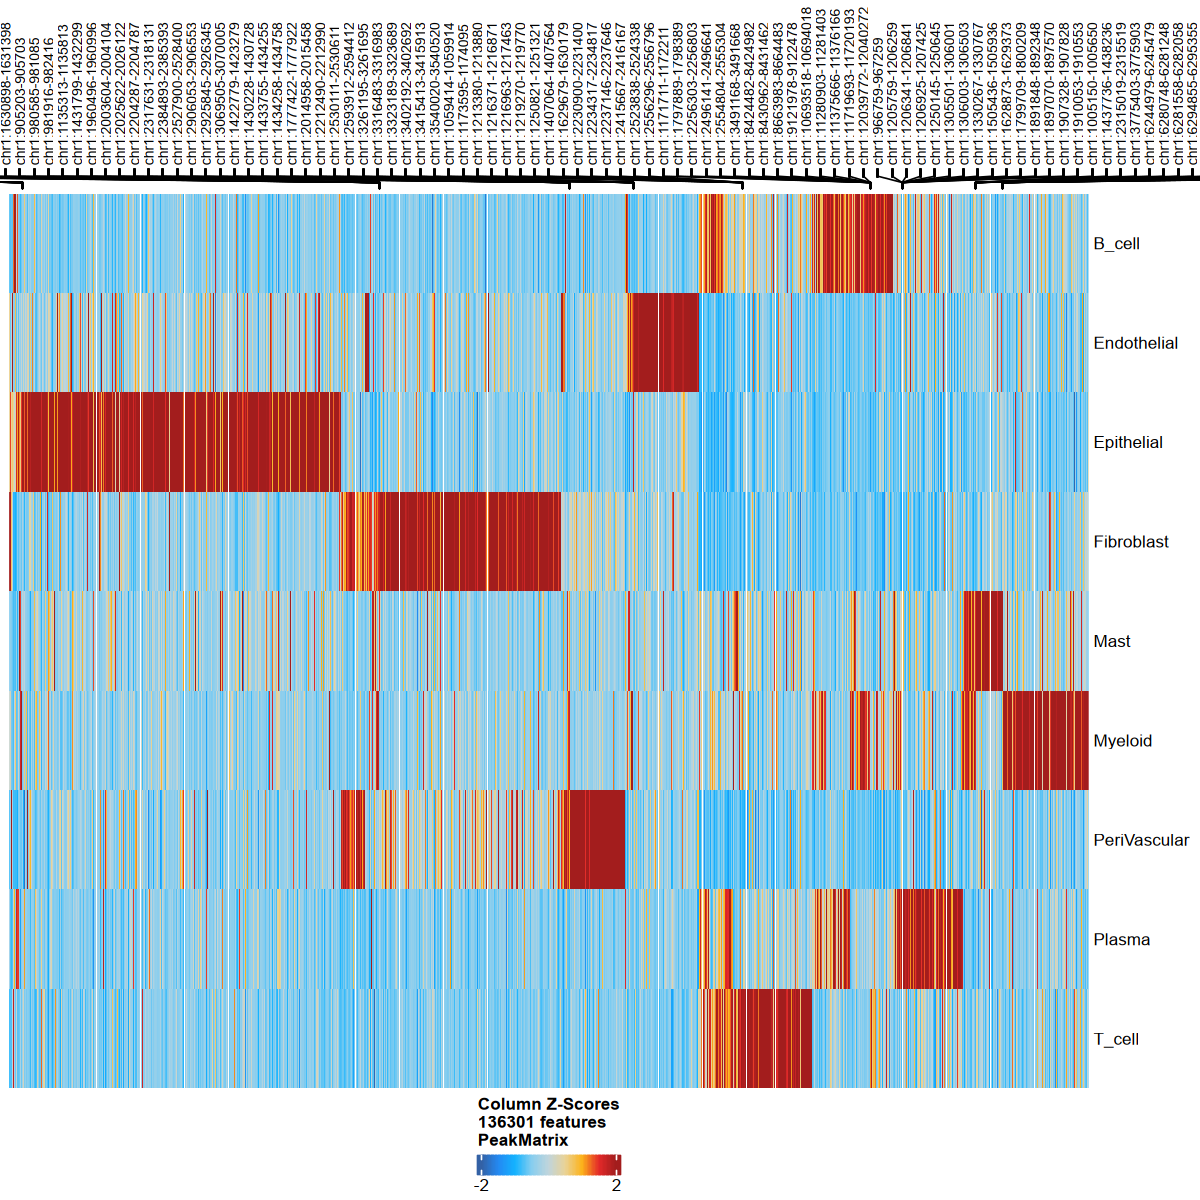

In [15]:
heatmapPeaks <- plotMarkerHeatmap(
    seMarker = PeakCellType,
    cutOff = "FDR < 0.01 & Log2FC >= 1",
    transpose = TRUE
)
options(repr.plot.height = 10, repr.plot.width = 10)
ComplexHeatmap::draw(heatmapPeaks, 
                     heatmap_legend_side = "bot", 
                     annotation_legend_side = "bot")

In [21]:
DAR <- getMarkers(PeakCellType, cutOff = "FDR < 0.01 & Log2FC >= 1")

In [22]:
#----- identify DARs，差异峰值分析

## DAR motif enrichment 差异峰值motif富集分析
enrichMotifs <- peakAnnoEnrichment(
  seMarker = PeakCellType,
  ArchRProj = proj,
  peakAnnotation = "homer",
  cutOff = "FDR < 0.01 & Log2FC >= 1"
)
enrichMotifs

ArchR logging to : ArchRLogs/ArchR-peakAnnoEnrichment-2e4b4f1293e8df-Date-2025-03-06_Time-08-45-56.812852.log
If there is an issue, please report to github with logFile!

2025-03-06 08:46:12.762642 : Computing Enrichments 1 of 9, 0.266 mins elapsed.

2025-03-06 08:46:12.996909 : Computing Enrichments 2 of 9, 0.27 mins elapsed.

2025-03-06 08:46:13.203962 : Computing Enrichments 3 of 9, 0.273 mins elapsed.

2025-03-06 08:46:13.43227 : Computing Enrichments 4 of 9, 0.277 mins elapsed.

2025-03-06 08:46:13.711317 : Computing Enrichments 5 of 9, 0.282 mins elapsed.

2025-03-06 08:46:13.899898 : Computing Enrichments 6 of 9, 0.285 mins elapsed.

2025-03-06 08:46:14.09917 : Computing Enrichments 7 of 9, 0.288 mins elapsed.

2025-03-06 08:46:14.298026 : Computing Enrichments 8 of 9, 0.291 mins elapsed.

2025-03-06 08:46:14.494798 : Computing Enrichments 9 of 9, 0.295 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-peakAnnoEnrichment-2e4b4f1293e8df-Date-2025-03-06_Time-08-45-56.81

class: SummarizedExperiment 
dim: 332 9 
metadata(0):
assays(10): mlog10Padj mlog10p ... CompareFrequency feature
rownames(332): AP.1.bZIP_1 AP.2gamma.AP2_2 ... ZNF711.Zf_331
  ZSCAN22.Zf_332
rowData names(0):
colnames(9): B_cell Endothelial ... Plasma T_cell
colData names(0):

In [23]:
library(grid)

In [24]:
heatmapMotif <- plotEnrichHeatmap(enrichMotifs, n = 7, clusterCols = F, transpose = TRUE)
options(repr.plot.height = 10, repr.plot.width = 10)
ComplexHeatmap::draw(heatmapMotif, 
                     heatmap_legend_side = "bot", 
                     annotation_legend_side = "bot")


ArchR logging to : ArchRLogs/ArchR-plotEnrichHeatmap-2e4b4f2854f131-Date-2025-03-06_Time-08-46-35.04802.log
If there is an issue, please report to github with logFile!



Adding Annotations..

Preparing Main Heatmap..



ERROR: Error in grid.Call.graphics(C_downvppath, name$path, name$name, strict): Viewport 'Norm. Enrichment -log10(P-adj) [0-Max]_heatmap_body_1_1' was not found


In [ ]:
### DAR返回GR对象基因区域（）
DAR_gr <- getMarkers(PeakCellType, cutOff = "FDR < 0.01 & Log2FC >= 1", returnGR = T)
### 导出差异峰值bed
lapply(names(DAR_gr), function(x){
  gr <- DAR_gr[[x]]
  mcols(gr) <- NULL
  rtracklayer::export.bed(gr, paste0("./output/output_bed/celltype_DAR/", x, "_DAR.bed"))
  return(NULL)
})

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

[[8]]
NULL

[[9]]
NULL

In [25]:
library(devtools)
install_github("jokergoo/ComplexHeatmap")

Skipping 3 packages ahead of CRAN: BiocGenerics, S4Vectors, IRanges



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/Rtmp7IpY68/remotes90c0c6797514a/jokergoo-ComplexHeatmap-3398d21/DESCRIPTION’ ... OK
* preparing ‘ComplexHeatmap’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘ComplexHeatmap_2.21.2.tar.gz’



In [ ]:
library(BiocManager)

Bioconductor version '3.18' is out-of-date; the current release version '3.19'
  is available with R version '4.4'; see https://bioconductor.org/install



In [ ]:
BiocManager::install("ComplexHeatmap")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cloud.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.22), R 4.3.1 (2023-06-16)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'ComplexHeatmap'”
Installation paths not writeable, unable to update packages
  path: /usr/lib/R/library
  packages:
    boot, codetools, foreign, KernSmooth, lattice, nlme, survival
  path: /usr/lib/R/site-library
  packages:
    backports, broom, cachem, callr, crayon, dbplyr, digest, farver, fastmap,
    fs, gtable, loo, munsell, pkgbuild, processx, ps, QuickJSR, ragg,
    RcppParallel, reprex, rstan, rstudioapi, rvest, StanHeaders, systemfonts,
    textshaping, tidyr, tidyselect, timechange, uuid, withr
  path: /usr/local/lib/R/site-library
  packages:
    basilisk, data.table, optparse, Sparse

In [26]:
library(ComplexHeatmap)

In [27]:
packageVersion("ComplexHeatmap")

[1] ‘2.21.2’

In [28]:
sessionInfo()

R version 4.4.1 (2024-06-14)
Platform: x86_64-conda-linux-gnu
Running under: Ubuntu 22.04.2 LTS

Matrix products: default
BLAS/LAPACK: /home/hanxue/miniconda3/envs/scseq/lib/libopenblasp-r0.3.21.so;  LAPACK version 3.9.0

Random number generation:
 RNG:     L'Ecuyer-CMRG 
 Normal:  Inversion 
 Sample:  Rejection 
 
locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
 [1] parallel  stats4    grid      stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] circlize_0.4.16                   nabor_0.5.0                      
 [3] BSgenome.Hsapiens.UCSC.hg38_1.4.5 BSgenome_1.72.0                  
 [5] rtracklayer_1.64.